# Transaction Classifier Model Development

This notebook builds a bilingual transaction classification model that categorizes financial text inputs into 15 predefined income categories (e.g., Salary, Bonus, Investment) using a deep learning architecture combining BiLSTM, CNN, and an attention mechanism. We preprocess the data using a Keras tokenizer and label encoder, and leverage pre-trained FastText embeddings for both English and Indonesian to support bilingual inputs. The model is trained on padded sequences and evaluated on a test set for accuracy. Finally, we save the trained model along with the tokenizer and label encoder to enable seamless inference on new transaction data.

`Notebook Author:` *Zev Hadid Santoso & Christian Julianto Sayono*

## Libraries

In [ ]:
# Install dependencies
!pip install numpy pandas matplotlib tensorflow

# Imports
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM, Bidirectional, Conv1D,
                                     GlobalMaxPooling1D, Dense, Dropout, Concatenate)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
import os
import shutil
import requests
import gzip

## Data Analysis

### Load Dataset

In [33]:
# Load data
df = pd.read_csv('transactions.csv').dropna(subset=['text', 'label'])
texts = df['text'].astype(str).tolist()
labels = df['label'].astype(str).tolist()

### Distribution Visualization

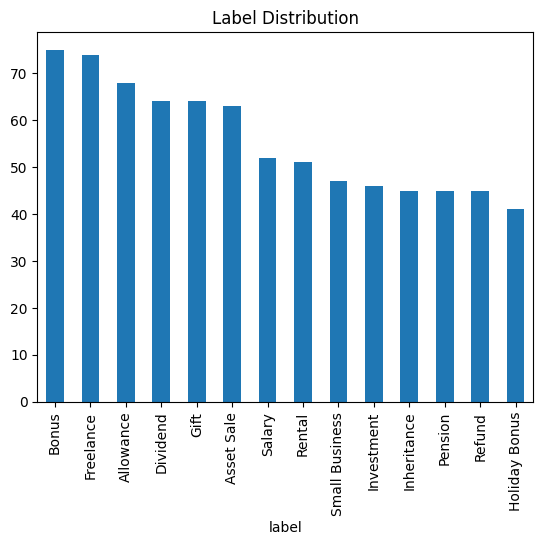

In [34]:
df['label'].value_counts().plot(kind='bar', title='Label Distribution')
plt.show()

## Model Development

### Download FastText Models

In [35]:
def download_and_extract_fasttext(url, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    if not os.path.exists(output_path):
        gz_path = output_path + '.gz'
        print(f"Downloading: {url}")
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(gz_path, 'wb') as f:
                shutil.copyfileobj(r.raw, f)
        print("Extracting...")
        with gzip.open(gz_path, 'rb') as f_in:
            with open(output_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        os.remove(gz_path)
        print(f"Saved to {output_path}")
    else:
        print(f"{output_path} already exists.")

In [36]:
# Paths
en_path = "../FastText_models/cc.en.300.vec"
id_path = "../FastText_models/cc.id.300.vec"

# URLs
en_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz"
id_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz"

# Download models
download_and_extract_fasttext(en_url, en_path)
download_and_extract_fasttext(id_url, id_path)


../FastText_models/cc.en.300.vec already exists.
../FastText_models/cc.id.300.vec already exists.


### Text Tokenization

In [37]:
# Tokenization
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
max_len = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')

### Label Encoding & Data Splitting

In [38]:
# Encode labels
allowed_labels = ['Allowance', 'Asset Sale', 'Bonus', 'Dividend', 'Freelance',
                  'Gift', 'Holiday Bonus', 'Inheritance', 'Investment',
                  'Pension', 'Refund', 'Rental', 'Salary', 'Small Business']
label_encoder = LabelEncoder()
label_encoder.fit(allowed_labels)
y = label_encoder.transform(labels)
y = tf.keras.utils.to_categorical(y, num_classes=len(allowed_labels))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Load & Merge FastText Embeddings

In [39]:
# Load FastText embeddings
def load_fasttext_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        next(f)
        for line in f:
            parts = line.rstrip().split()
            word = parts[0]
            vector = np.asarray(parts[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

embedding_en = load_fasttext_embeddings(en_path)
embedding_id = load_fasttext_embeddings(id_path)

# Create embedding matrix
embedding_dim = 300
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))
for word, i in word_index.items():
    vec = embedding_id.get(word)
    if vec is None:
        vec = embedding_en.get(word)
    if vec is not None:
        embedding_matrix[i] = vec

### Model Architecture

In [40]:
# Define custom attention layer
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        alpha = K.softmax(e, axis=1)
        context = inputs * alpha
        context = K.sum(context, axis=1)
        return context
    
# Build model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)(input_layer)

lstm_out = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
cnn_out = Conv1D(64, 3, activation='relu')(lstm_out)
cnn_out = GlobalMaxPooling1D()(cnn_out)

attention_out = AttentionLayer()(lstm_out)

combined = Concatenate()([cnn_out, attention_out])
combined = Dropout(0.3)(combined)
output = Dense(len(allowed_labels), activation='softmax')(combined)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\zevha\Moment\moment\machine-learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 9, 300)    │    268,200 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 9, 128)    │    186,880 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 7, 64)     │     24,640 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_1   │ (None, 128)       │        137 │ bidirectional_1[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 192)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 192)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 14)        │      2,702 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 482,559 (1.84 MB)

 Trainable params: 214,359 (837.34 KB)

 Non-trainable params: 268,200 (1.02 MB)

### Model Training & Evaluation

In [41]:
# Train model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2%}")

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1063 - loss: 2.6370 - val_accuracy: 0.1410 - val_loss: 2.5769
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2558 - loss: 2.5501 - val_accuracy: 0.3397 - val_loss: 2.4605
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3300 - loss: 2.3841 - val_accuracy: 0.4679 - val_loss: 2.0835
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4604 - loss: 1.8604 - val_accuracy: 0.6090 - val_loss: 1.3224
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5921 - loss: 1.2485 - val_accuracy: 0.7051 - val_loss: 0.8952
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6962 - loss: 0.8747 - val_accuracy: 0.7628 - val_loss: 0.8174
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7580 - loss: 0.6701 - val_accuracy: 0.8141 - val_loss: 0.6065
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8167 - loss: 0.5483 - val_accuracy: 0.8013 - v

## Save Model & Artifacts

In [ ]:
# Save artifacts
folder_path = 'model_artifacts'
tokenizer_path = os.path.join(folder_path, 'tokenizer.pkl')
label_encoder_path = os.path.join(folder_path, 'label_encoder.pkl')
model_path = os.path.join(folder_path, "transaction_classifier_model.keras")

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
os.makedirs(folder_path, exist_ok=True)

with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)

with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)

model.save(model_path)

## Model Inference

### Load Saved Model & Artifacts

In [ ]:
# Load for inference
from tensorflow.keras.models import load_model

model = load_model(model_path, custom_objects={'AttentionLayer': AttentionLayer})

with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

with open(label_encoder_path, 'rb') as f:
    label_encoder = pickle.load(f)

### Prediction

In [44]:
# Prediction function
def predict_transaction(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=model.input_shape[1], padding='post')
    pred = model.predict(padded)
    label_index = np.argmax(pred)
    label = label_encoder.inverse_transform([label_index])[0]
    return label, float(np.max(pred))

In [47]:
# Test samples
sample_text_en = "pension from the government"
label_en, conf_en = predict_transaction(sample_text_en)
print(f"Prediction: {label_en} ({conf_en:.2%} confidence)")

sample_text_id = "menyimpan uang di bank"
label_id, conf_id = predict_transaction(sample_text_id)
print(f"Prediction: {label_id} ({conf_id:.2%} confidence)")

sample_text_id = "mengirim hadiah untuk anak"
label_id, conf_id = predict_transaction(sample_text_id)
print(f"Prediction: {label_id} ({conf_id:.2%} confidence)")

sample_text_en = "received my monthly salary"
label_en, conf_en = predict_transaction(sample_text_en)
print(f"Prediction: {label_en} ({conf_en:.2%} confidence)")

sample_text_en = "got holiday bonus from company"
label_en, conf_en = predict_transaction(sample_text_en)
print(f"Prediction: {label_en} ({conf_en:.2%} confidence)")

sample_text_en = "dividend from my stock investments"
label_en, conf_en = predict_transaction(sample_text_en)
print(f"Prediction: {label_en} ({conf_en:.2%} confidence)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Prediction: Pension (61.71% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction: Investment (62.70% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction: Gift (67.94% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction: Salary (69.40% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction: Holiday Bonus (91.70% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction: Dividend (83.95% confidence)
